In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

%env NVIDIA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=3

!echo $NVIDIA_VISIBLE_DEVICES
!echo $CUDA_VISIBLE_DEVICES

DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

env: NVIDIA_VISIBLE_DEVICES=1
env: CUDA_VISIBLE_DEVICES=3
1
3


device(type='cuda', index=0)

In [3]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader

## Set up training data & parameters:

In [4]:
from sklearn.model_selection import train_test_split
import ts_dataset as ds
import utils

price_data = pd.read_csv('datasets/btc-usdt-1.csv')

input_data = ((price_data.bid_price + price_data.ask_price) / 2).values

train_data, val_data = train_test_split(input_data, test_size=0.33)
train_data.shape, val_data.shape

((57888,), (28512,))

In [13]:
def get_dataloader(data, enc_seq_len=60, dec_seq_len=120, step_size=1, batch_first=True, batch_size=None):
    '''
    E.g. if you want the model to consider the past 100
    time steps in order to predict the future 50 
    time steps, window_size = 100+50 = 150
    
    Args:
    
        enc_seq_len: int, length of input given to encoder

        dec_seq_len: int, length of input given to decoder
        
        step_size: int, Step size, i.e. how many time steps does the moving window move at each step
            
    '''
    
    output_sequence_length = dec_seq_len # target sequence length. If hourly data and length = 48, you predict 2 days ahead

    window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
   
    indices = utils.get_indices_entire_sequence(
        data=data, 
        window_size=window_size, 
        step_size=step_size
    )

    # Making instance of custom dataset class
    data = ds.TransformerDataset(
        data=torch.FloatTensor(data).unsqueeze(1),
        indices=indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=dec_seq_len,
        target_seq_len=output_sequence_length
    )

    # Making dataloader
    return DataLoader(data, batch_size, shuffle=False, num_workers=40) # replace 40 with your number

In [14]:
BATCH_SIZE=64

train_loader = get_dataloader(train_data, batch_size=BATCH_SIZE)
val_loader = get_dataloader(val_data, batch_size=BATCH_SIZE)

From get_src_trg: data size = torch.Size([57888, 1])
From get_src_trg: data size = torch.Size([28512, 1])


## PyTorch Lightning section

### Importing module with your model

In [19]:
import gc
gc.collect(), torch.cuda.empty_cache()

(4799, None)

In [20]:
import baseline as tst # replace with your model import
from model import SeqNet # needed

enc_seq_len=60
dec_seq_len=120

N_EPOCHS=30

backbone_net = tst.TimeSeriesTransformer(
    input_size=1, # num of input features
    dec_seq_len=enc_seq_len, # like in get_dataloader
    batch_first=True,
    num_predicted_features=1
)

model = SeqNet(
    backbone_net=backbone_net,
    forecast_window=dec_seq_len,
    enc_seq_len=enc_seq_len,
    n_epochs=N_EPOCHS, # needed for lr scheduling
).to(DEVICE)

### Initializing logging and checkpointing params

In [21]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

wb_logger = pl.loggers.WandbLogger(
    name=f"TS_transformer_baseline|n_epochs={N_EPOCHS}|batch_size={BATCH_SIZE}",
    project='sequential_data'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_MSE', # name of SeqNet attribute
    filename='{epoch:02d}-{val_f1:.3f}',
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    logger=wb_logger,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | TimeSeriesTransformer | 29.4 M
1 | criterion | MSELoss               | 0     
2 | mae       | L1Loss                | 0     
3 | train_mse | MeanSquaredError      | 0     
4 | val_mse   | MeanSquaredError      | 0     
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.713   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

#### Random output validation

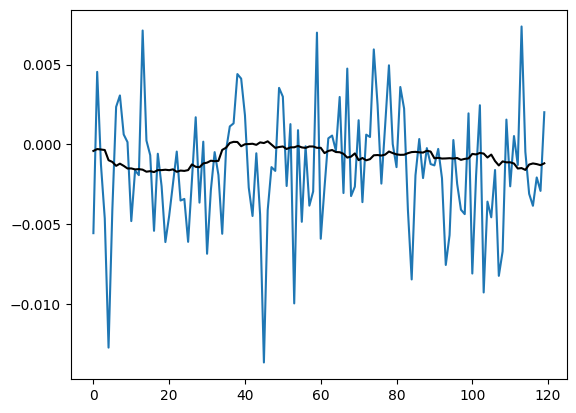

In [96]:
idx=13

plt.plot(prediction[idx].detach().squeeze().numpy())

plt.plot(tgt_y[idx].detach().squeeze().cpu().numpy(), c='k')

plt.show()